In [80]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.signal import fftconvolve
from skimage import restoration
from scipy import signal, fft

## Creating a sample image

(-0.5, 14.5, 14.5, -0.5)

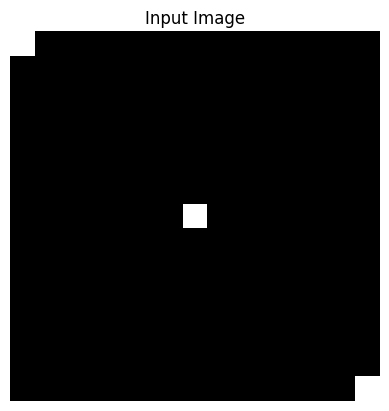

In [160]:
side = 15
x = np.zeros((side, side), dtype=np.float32)
x[0, 0] = 1.0
x[side//2, side//2] = 1.0
x[side-1, side-1] = 1.0
plt.imshow(x, cmap='gray')
plt.title('Input Image')
plt.axis('off')

## Creating the blur kernels

(-0.5, 2.5, 2.5, -0.5)

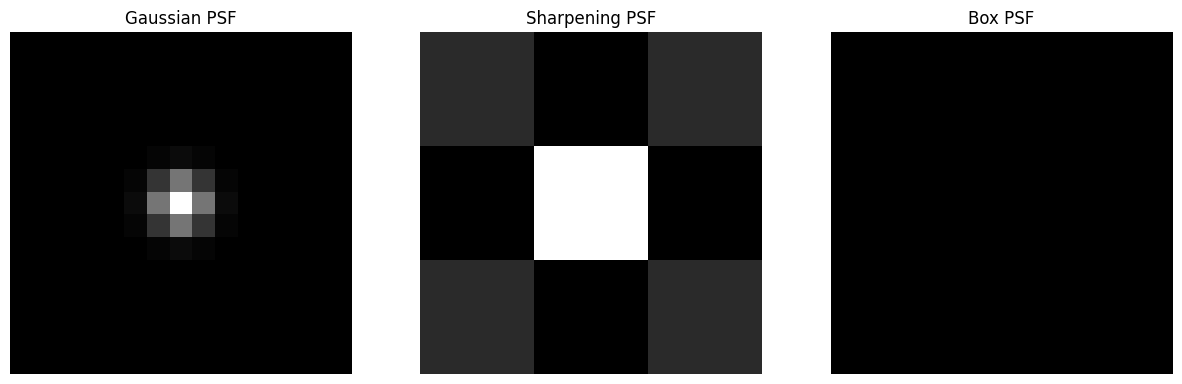

In [161]:
def gaussian_kernel(size, sigma):
    """Generates a Gaussian kernel."""
    # From ChatGPT
    ax = np.linspace(-(size // 2), size // 2, size)     # Create range of values centered around 0. len(ax) = size
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

def sharpen():
    return np.array([[0, -1, 0],
                     [-1, 5, -1],
                     [0, -1, 0]], dtype=np.float32)

def box_blur():
    return np.array([[1, 1, 1],
                     [1, 1, 1],
                     [1, 1, 1]], dtype=np.float32) / 9.0

psf_gauss = gaussian_kernel(side, sigma=0.8)
psf_sharp = sharpen()
psf_box = box_blur()
fig1, arr = plt.subplots(1, 3 ,figsize=(15, 10))
arr[0].imshow(psf_gauss, cmap='gray')
arr[0].set_title('Gaussian PSF')
arr[0].axis('off')
arr[1].imshow(psf_sharp, cmap='gray')
arr[1].set_title('Sharpening PSF')
arr[1].axis('off')
arr[2].imshow(psf_box, cmap='gray')
arr[2].set_title('Box PSF')
arr[2].axis('off')

## Convolving Image with the blur kernels

(-0.5, 14.5, 14.5, -0.5)

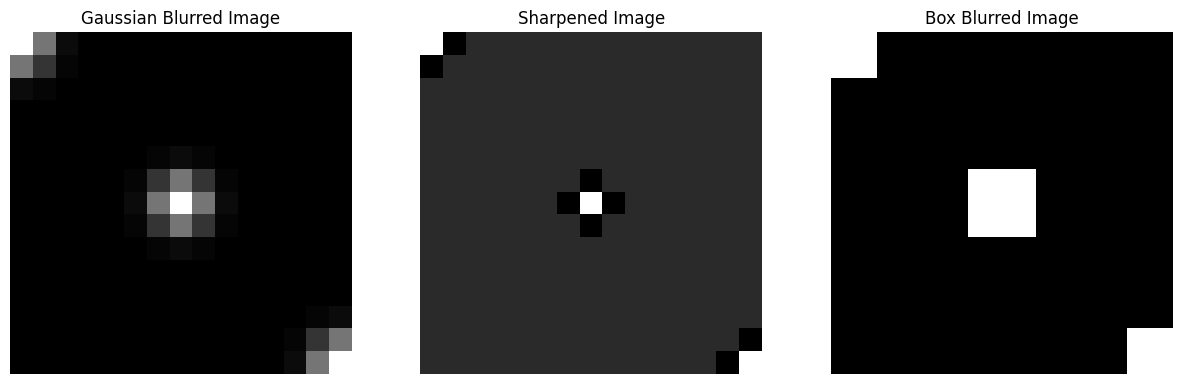

In [162]:
blurred_gauss = scipy.signal.convolve2d(x, psf_gauss, "same", boundary="fill", fillvalue=0.0)
blurred_sharp = scipy.signal.convolve2d(x, psf_sharp, "same", boundary="fill", fillvalue=0.0)
blurred_box = scipy.signal.convolve2d(x, psf_box, "same", boundary="fill", fillvalue=0.0)

fig2, arr = plt.subplots(1, 3 ,figsize=(15, 10))
arr[0].imshow(blurred_gauss, cmap='gray')
arr[0].set_title('Gaussian Blurred Image')
arr[0].axis('off')
arr[1].imshow(blurred_sharp, cmap='gray')
arr[1].set_title('Sharpened Image')
arr[1].axis('off')
arr[2].imshow(blurred_box, cmap='gray')
arr[2].set_title('Box Blurred Image')
arr[2].axis('off')

## Use Richardson-Lucy algorithm to deconvolve

(-0.5, 14.5, 14.5, -0.5)

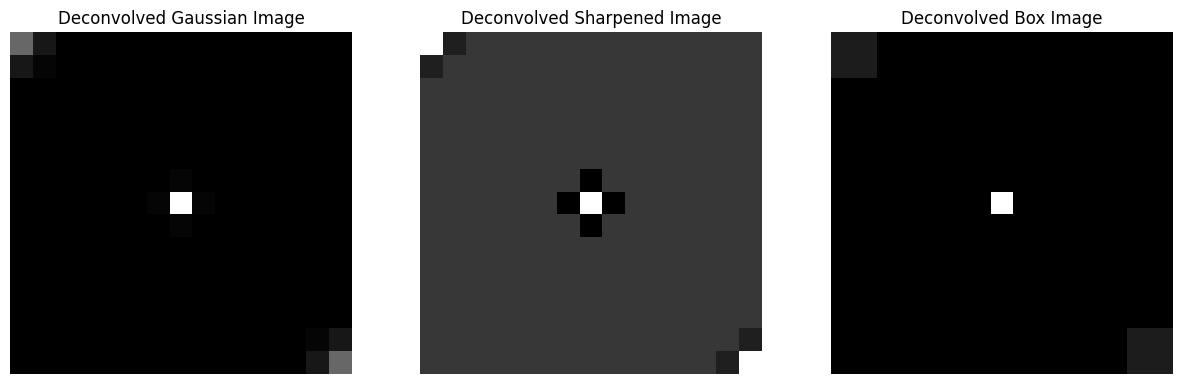

In [163]:
deconvolved_gauss = restoration.richardson_lucy(blurred_gauss, psf_gauss, num_iter=30)
deconvolved_sharp = restoration.richardson_lucy(blurred_sharp, psf_sharp, num_iter=30)
deconvolved_box = restoration.richardson_lucy(blurred_box, psf_box, num_iter=30)

fig3, arr = plt.subplots(1, 3 ,figsize=(15, 10))
arr[0].imshow(deconvolved_gauss, cmap='gray')
arr[0].set_title('Deconvolved Gaussian Image')
arr[0].axis('off')
arr[1].imshow(deconvolved_sharp, cmap='gray')
arr[1].set_title('Deconvolved Sharpened Image')
arr[1].axis('off')
arr[2].imshow(deconvolved_box, cmap='gray')
arr[2].set_title('Deconvolved Box Image')
arr[2].axis('off')

## Blind deconvolution of blur kernels

(-0.5, 14.5, 14.5, -0.5)

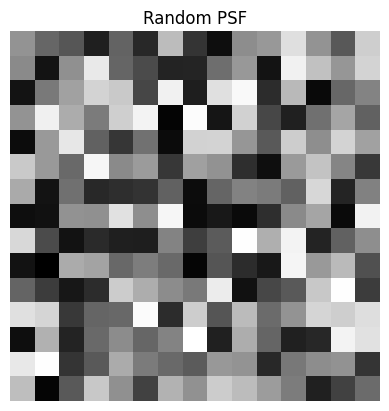

In [189]:
psf_est = np.random.rand(*blurred_gauss.shape)  # Fix the random psf for debugging

plt.imshow(psf_est, cmap='gray')
plt.title('Random PSF')
plt.axis('off')

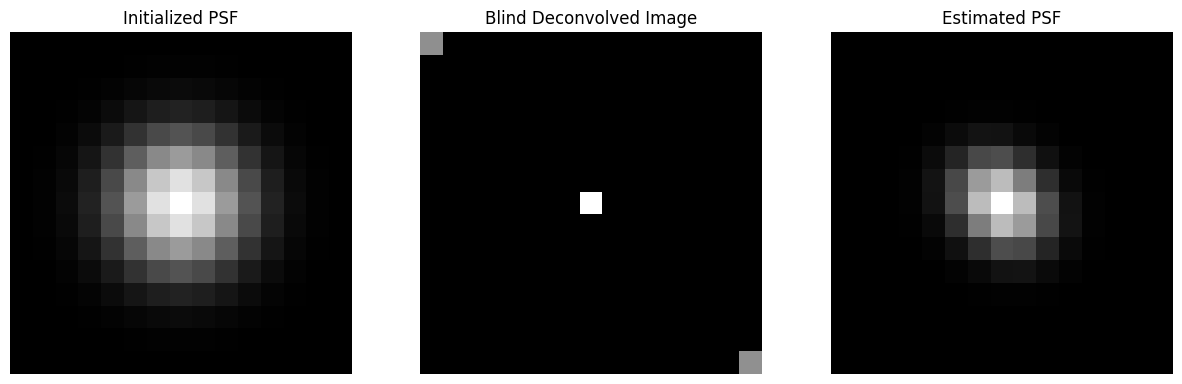

In [194]:
from scipy.signal import convolve2d

def initialize_psf(shape, size=7, sigma=1.5):
    psf = np.zeros(shape)
    center = (shape[0] // 2, shape[1] // 2)
    y, x = np.ogrid[:shape[0], :shape[1]]
    mask = np.exp(-((x - center[1]) ** 2 + (y - center[0]) ** 2) / (2 * sigma ** 2))
    mask /= mask.sum()
    psf += mask
    return psf

def total_variation(image):
    """Calculating Total Variation for an image."""
    if len(image.shape) == 2:
        pixel_dif1 = image[1:, :] - image[:-1, :]
        pixel_dif2 = image[:, 1:] - image[:, :-1]
    elif len(image.shape) == 3:
        pixel_dif1 = image[1:, :, :] - image[:-1, :, :]
        pixel_dif2 = image[:, 1:, :] - image[:, :-1, :]
    else:
        raise ValueError("Image must be 2D or 3D.")
    return np.sum(np.abs(pixel_dif1)) + np.sum(np.abs(pixel_dif2))

# def blind_richardson_lucy(blurred, psf_est, delta=0.1, lmda=0.2, num_iter=30):
#     """Blind deconvolution using Richardson-Lucy algorithm."""
#     # Initialize the estimate of the image and random PSF
#     img_est = np.ones_like(blurred)
#     #psf_est = np.random.rand(*blurred.shape)     # * unpacks the tuple into (# dimensions) integers, in this case, 2 integers
#     psf_est = psf_est 
    
#     for _ in range(num_iter):
#         # Update the image estimate
#         psf_adjoint = np.flip(psf_est)       # the psf is the conjugate transpose of the PSF, but since our values are real, we can just take the transpose
#         # conv = fftconvolve(img_est, psf_est, mode='same')
#         # relative_blur = blurred / (conv + 1e-8)   # Adding a small value to avoid division by zero
#         # img_est = img_est * fftconvolve(relative_blur, psf_adjoint, mode='same')   # Equation 30 from https://arxiv.org/ftp/arxiv/papers/1206/1206.3594.pdf
#         # Had to use regularization to avoid division by zero
#         first_term = fftconvolve(psf_adjoint, blurred, mode='same')      
#         second_term = fftconvolve(fftconvolve(psf_adjoint, psf_est, mode='same'), img_est, mode='same')      
#         img_est = img_est + delta * (first_term - second_term + lmda*total_variation(img_est))   # Equation 32 from https://arxiv.org/ftp/arxiv/papers/1206/1206.3594.pdf

#         # Update the psf estimate
#         img_adjoint = np.flip(img_est)
#         new_estimate = fftconvolve(img_est, psf_est, mode='same')
#         psf_est = psf_est * fftconvolve(img_adjoint, (blurred / (new_estimate + 1e-8)), mode='same')   # Equation 31 from https://arxiv.org/ftp/arxiv/papers/1206/1206.3594.pdf
#     return img_est, psf_est

# # delta is the relaxation parameter and lambda is the regularization parameter
# img_est_result, psf_est_result = blind_richardson_lucy(blurred_gauss, psf_est, delta=0.15, lmda=0.01, num_iter=10)


def blind_richardson_lucy(blurred, psf_est, delta=0.1, lmda=0.01, num_iter=50):
    """Blind deconvolution using Richardson-Lucy algorithm."""
    # Initialize the estimate of the image and random PSF
    img_est = np.full_like(blurred, 0.5) 
    psf_size = psf_est.shape

    for _ in range(num_iter):
        # Update the image estimate
        conv = convolve2d(img_est, psf_est, mode='same', boundary='wrap')
        relative_blur = blurred / (conv + 1e-8)  # Avoid division by zero
        img_update = convolve2d(relative_blur, np.flip(psf_est), mode='same', boundary='wrap')
        
        # regularize
        tv_grad_x = np.diff(img_est, axis=1, append=img_est[:, -1:])
        tv_grad_y = np.diff(img_est, axis=0, append=img_est[-1:, :])
        tv_gradient = (np.gradient(tv_grad_x)[0] + np.gradient(tv_grad_y)[1])
        
        # update using regularize
        img_est *= img_update
        img_est -= delta * lmda * tv_gradient
        img_est = np.clip(img_est, 0, None)
        
        # update psf
        psf_update = convolve2d(img_est, blurred / (conv + 1e-8), mode='same', boundary='wrap')
        psf_est = psf_est * psf_update
        psf_est = np.clip(psf_est, 0, None)
        psf_est /= psf_est.sum()
        
        psf_est = convolve2d(psf_est, gaussian_kernel(psf_size[0], sigma=1.0), mode='same')
        psf_est /= psf_est.sum()

    return img_est, psf_est

psf_est = initialize_psf(blurred_gauss.shape, sigma=2)

img_est_result, psf_est_result = blind_richardson_lucy(blurred_gauss, psf_est, delta=0.1, lmda=0.01, num_iter=50)

fig, arr = plt.subplots(1, 3, figsize=(15, 6))

arr[0].imshow(psf_est, cmap='gray')
arr[0].set_title('Initialized PSF')
arr[0].axis('off')

arr[1].imshow(img_est_result, cmap='gray')
arr[1].set_title('Blind Deconvolved Image')
arr[1].axis('off')

arr[2].imshow(psf_est_result, cmap='gray')
arr[2].set_title('Estimated PSF')
arr[2].axis('off')

plt.show()

(-0.5, 14.5, 14.5, -0.5)

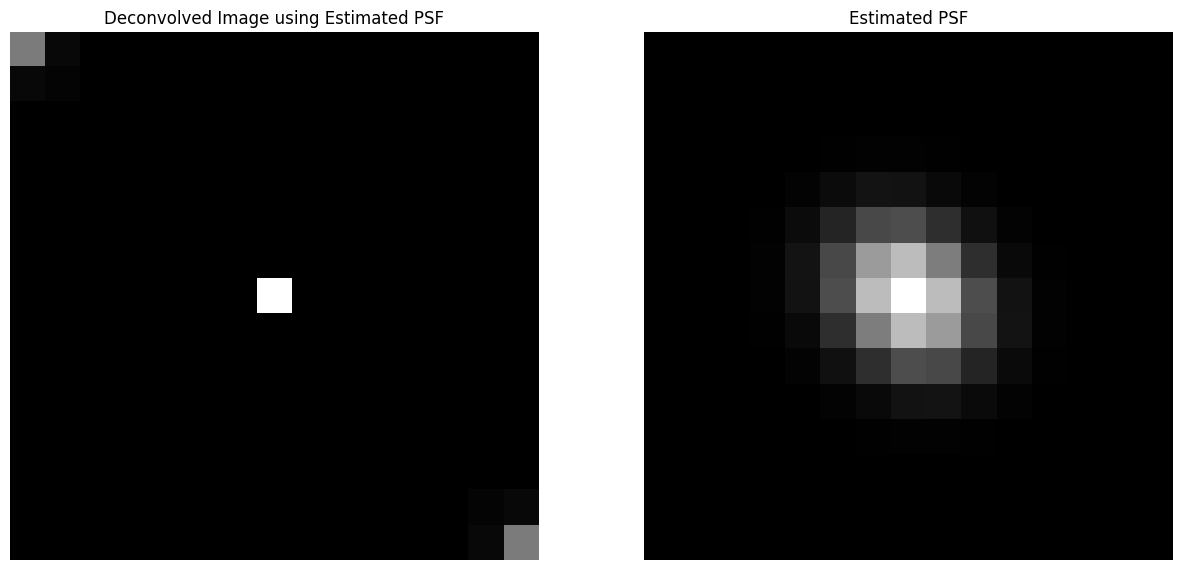

In [195]:
# Now using estimate PSF to deconvolve the image
deconvolved_img = restoration.richardson_lucy(blurred_gauss, psf_est_result, num_iter=30)

fig5, arr = plt.subplots(1, 2, figsize=(15, 10))
arr[0].imshow(deconvolved_img, cmap='gray')
arr[0].set_title('Deconvolved Image using Estimated PSF')
arr[0].axis('off')
arr[1].imshow(psf_est_result, cmap='gray')
arr[1].set_title('Estimated PSF')
arr[1].axis('off')